In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import yfinance as yf
import pypfopt 
import matplotlib.pyplot as plt

from pypfopt import black_litterman, plotting, objective_functions, risk_models
from pypfopt import BlackLittermanModel
from pypfopt.efficient_frontier import EfficientFrontier

In [2]:
tickers = ["TSLA", "NVDA", "AMZN", "META", "MSFT", "AAPL", "AMD"] # Initial asset universe
start_date = '2013-01-01'
end_date = '2024-01-01'

data = yf.download(tickers, start=start_date, end=end_date)
data.to_csv("./Data/historical_data.csv")

closing_prices = data["Adj Close"]

returns = np.log(closing_prices / closing_prices.shift(1).dropna())

def get_market_prices_and_caps(tickers, start_date, end_date):
    # VOO is Vanguard S&P 500 ETF
    market_prices = yf.download("VOO", start=start_date, end=end_date)["Adj Close"]
    # market_returns = np.log(market_prices / market_prices.shift(1)).dropna() 

    market_caps = {}
    for ticker in tickers:
        stock = yf.Ticker(ticker)
        market_caps[ticker] = stock.info.get("marketCap", None)  # Get market cap, with None if missing

    return market_prices, market_caps

closing_prices.tail()

[*********************100%***********************]  7 of 7 completed


Ticker,AAPL,AMD,AMZN,META,MSFT,NVDA,TSLA
Date,,,,,,,
2023-12-22 00:00:00+00:00,192.656174,139.600006,153.419998,352.329193,371.799713,48.819527,252.539993
2023-12-26 00:00:00+00:00,192.108871,143.410004,153.410004,353.764832,371.879150,49.268425,256.609985
2023-12-27 00:00:00+00:00,192.208359,146.070007,153.339996,356.755859,371.293518,49.406395,261.440002
2023-12-28 00:00:00+00:00,192.636276,148.759995,153.380005,357.244385,372.494507,49.511375,253.179993
2023-12-29 00:00:00+00:00,191.591385,147.410004,151.940002,352.897461,373.248871,49.511375,248.479996


<Axes: >

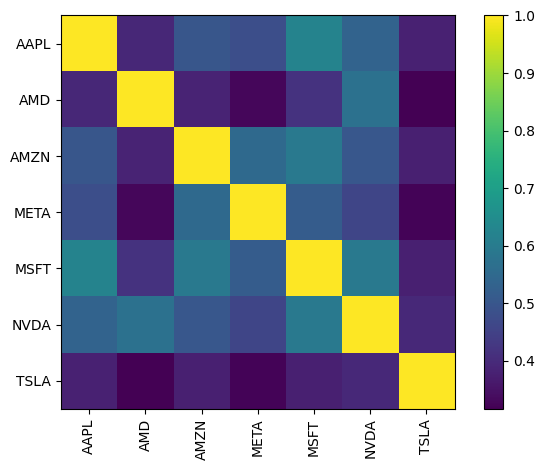

In [5]:
covariance_matrix = returns.cov()
plotting.plot_covariance(covariance_matrix, plot_correlation=True)

[*********************100%***********************]  1 of 1 completed


<Axes: ylabel='Ticker'>

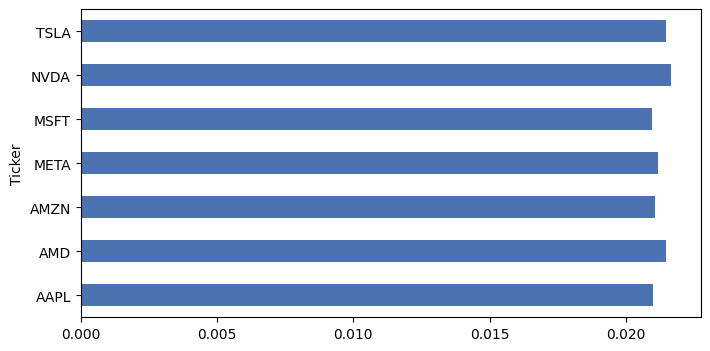

In [7]:
market_prices, market_caps = get_market_prices_and_caps(tickers, start_date, end_date)
delta = black_litterman.market_implied_risk_aversion(market_prices)
prior = black_litterman.market_implied_prior_returns(market_caps, delta, covariance_matrix)

prior.plot.barh(figsize=(8,4))

### Get Fear-Greed Score

In [ ]:
# indicators to define:
# done - Stock Price Momentum: A measure of the S&P 500 versus its 125-day moving average (MA)
# done - Stock Price Strength: The number of stocks hitting 52-week highs versus those hitting 52-week lows on the New York Stock Exchange (NYSE).
# done - Stock Price Breadth: Analyzing the trading volumes in rising stocks against declining stocks.

# todo: Put and Call Options: The extent to which put options lag behind call options, signifying greed, or surpasses them, indicating fear.
# todo: Junk Bond Demand: Measures the spread between yields on investment-grade bonds and junk bonds.
# todo: Market Volatility: The CBOE's Volatility Index (VIX) based on a 50-day MA.
# todo: Safe Haven Demand: The difference in returns for stocks versus treasuries.

def get_fear_greed(tickers, start_date='2023-01-01', end_date='2024-01-01'):
    fear_greed_scores_dict = {}

    for ticker in tickers:
        try:
            # calculate each indicator for the stock
            rsi = calculate_stock_rsi(ticker, start_date=start_date, end_date=end_date).iloc[-1]['RSI']
            price_strength, high, low, current_price = calculate_stock_price_strength(ticker)
            breadth_data = calculate_stock_price_breadth(ticker, start=start_date, end=end_date)

            # normalise each indicator (as rsi is from 0-100 etc)
            normalised_rsi = rsi / 100
            normalised_price_strength = price_strength
            latest_breadth_ratio = breadth_data['breadth_ratio'].iloc[-1]
            normalised_breadth = min(max(latest_breadth_ratio / 2, 0), 1)

            # weights for each indicator
            rsi_weight = 0.4
            price_strength_weight = 0.3
            breadth_weight = 0.3

            # calculate the FG score
            fear_greed_score = (
                normalised_rsi * rsi_weight +
                normalised_price_strength * price_strength_weight +
                normalised_breadth * breadth_weight
            )

            fear_greed_scores_dict[ticker] = fear_greed_score

        except Exception as error:
            print(f"An error has occured for {ticker}: {error}")
            fear_greed_scores_dict[ticker] = None

    return fear_greed_scores_dict

# Relative Strength Index (RSI)
def calculate_stock_rsi(tickers, period=14, start_date="2023-01-01", end_date="2024-01-01"):
    rsi_dict = {}
    
    for ticker in tickers:
        stock_data = yf.download(ticker, start=start_date, end=end_date)
        stock_data['Change'] = stock_data['Close'].diff()
        stock_data['Gain'] = np.where(stock_data['Change'] > 0, stock_data['Change'], 0)
        stock_data['Loss'] = np.where(stock_data['Change'] < 0, -stock_data['Change'], 0)

        stock_data['Avg_Gain'] = stock_data['Gain'].rolling(window=period, min_periods=1).mean()
        stock_data['Avg_Loss'] = stock_data['Loss'].rolling(window=period, min_periods=1).mean()

        stock_data['RS'] = stock_data['Avg_Gain'] / stock_data['Avg_Loss']
        stock_data['RSI'] = 100 - (100 / (1 + stock_data['RS']))

        rsi_dict[ticker] = stock_data[['Close', 'RSI']].dropna()
    
    return rsi_dict

def calculate_stock_price_strength(ticker):
    stock_data = yf.Ticker(ticker)
    stock_history = stock_data.history(period="1y")

    high = stock_history['Close'].max()
    low = stock_history['Close'].min()
    current_price = stock_history['Close'].iloc[-1]

    proximity_to_high = (current_price - low) / (high - low)
    return proximity_to_high, high, low, current_price

def calculate_stock_price_breadth(ticker, start, end):
    close_data = data['Close']
    volume_data = yf.download(ticker, start=start, end=end)['Volume']

    price_change = data.pct_change().fillna(0)
    results = pd.DataFrame(index=data.index)

    results['rising_volume'] = np.where(price_change > 0, volume_data, 0)
    results['declining_volume'] = np.where(price_change < 0, volume_data, 0)

    results['breadth_ratio'] = results['rising_volume'].sum() / results['declining_volume'].sum()
    return results

    # Example usage:
    # fear_greed_scores = get_fear_greed(all_tickers, start_date='2023-01-01', end_date='2024-01-01')
    # plot_fear_greed_scores(fear_greed_scores)

# fear_greed_scores = get_fear_greed(tickers, start_date='2023-01-01', end_date='2024-01-01')
# print(fear_greed_scores) # 0-1, higher score is greedier

# def calculate_put_call_ratio():
# High Put-Call Ratio is Bearish
# Low Put-Cal Ratio is Bullish

TypeError: 'Axes' object is not iterable

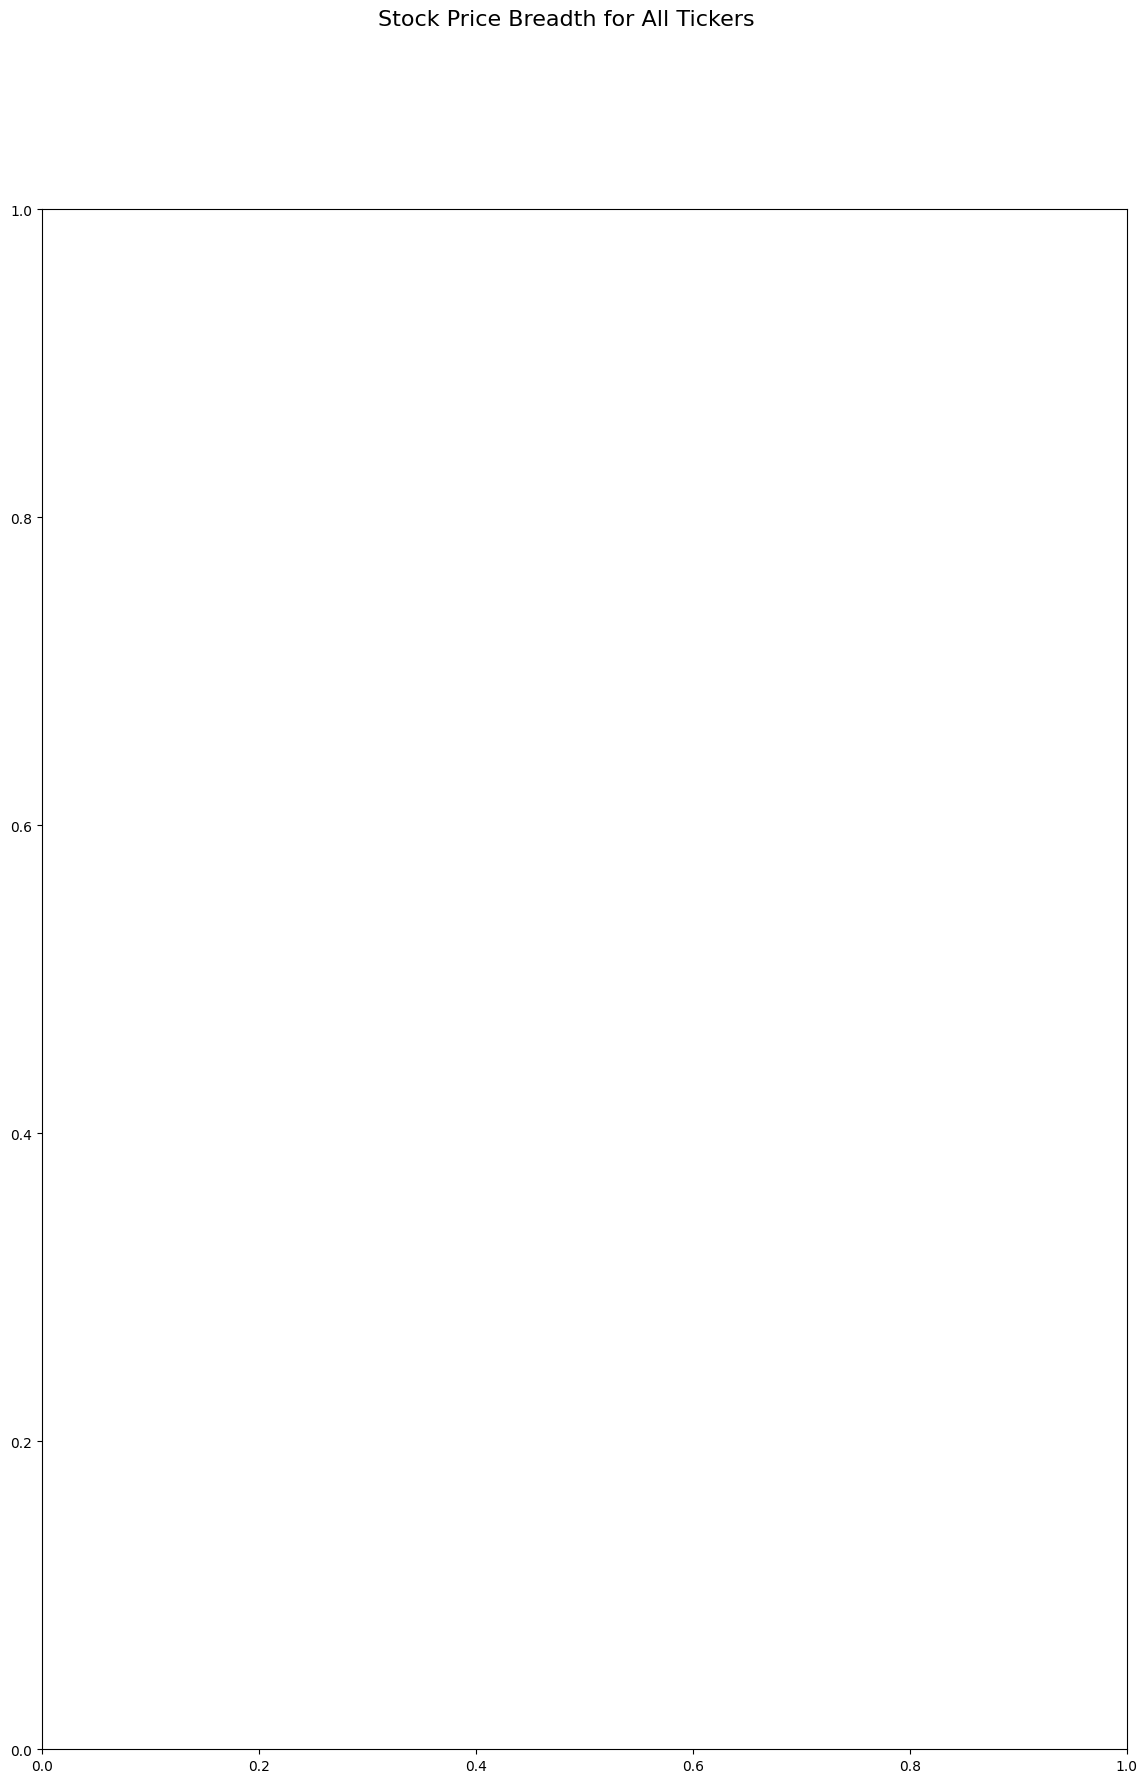

In [ ]:
def plot_stock_rsi(ticker: str, start_date: str = "2023-01-01", end_date: str = "2024-01-01"):
    fig, axes = plt.subplots(nrows=7, ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Relative Strength Index (RSI)')

    for ax, ticker in zip(axes, tickers):
        ax.plot(rsi[ticker].index, rsi[ticker]['RSI'], label=ticker)
        ax.axhline(70, color='red', linestyle='--', label='Overbought (70)')
        ax.axhline(30, color='green', linestyle='--', label='Oversold (30)')
        ax.set_title(ticker)
        ax.set_ylabel('RSI')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_stock_price_strength(tickers: list):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Stock Price Strength')

    for ax, ticker in zip(axes, tickers):
        proximity_to_high, high, low, current_price = calculate_stock_price_strength(ticker)

        stock_data = yf.Ticker(ticker)
        stock_history = stock_data.history(period="1y")

        ax.plot(stock_history.index, stock_history['Close'], label='Close price', color='blue')
        ax.axhline(high, color='red', linestyle='--', label='52 week high')
        ax.axhline(low, color='green', linestyle='--', label='52 week low')
        ax.scatter(stock_history.index[-1], current_price, color='purple', label=f'Current Price (Proximity: {proximity_to_high:.2f})')

        ax.set_title(ticker)
        ax.set_ylabel('Price')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

def plot_stock_price_breadth(tickers: list):
    fig, axes = plt.subplots(nrows=len(tickers), ncols=1, figsize=(14, 20), sharex=True)
    fig.suptitle('Stock Price Breadth')

    for ax, ticker in zip(axes, tickers):
        breadth_data = calculate_stock_price_breadth(ticker, start=start_date, end=end_date)
        ax.plot(breadth_data.index, breadth_data['breadth_ratio'], label=ticker)
        ax.axhline(1, color='red', linestyle='--', label='Neutral (1)')
        ax.set_title(ticker)
        ax.set_ylabel('Breadth Ratio')
        ax.legend(loc='upper left')
        ax.grid(True)

    axes[-1].set_xlabel('Date')
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# plot_stock_rsi(tickers)
# plot_stock_price_strength(tickers)
plot_stock_price_breadth(tickers)

### Convert to Views

In [ ]:
# convert FG score into views
bullish_threshold = 70
bearish_threshold = 30

fg_based_views = []
fg_based_confidences = []

for i, stock in enumerate(tickers):
    stock_score = get_fear_greed(tickers)

    if stock_score > bullish_threshold:
        view_returns = 0.02 + (stock_score - bullish_threshold) * 0.0001
    elif stock_score < bearish_threshold:
        view_returns = -0.02 + (bearish_threshold - stock_score) * 0.0001
    else:
        view_returns = 0.0 # neutral score if not bullish or bearish

    fg_based_views.append(view_returns)

    confidence = abs(stock_score - 50) / 100
    fg_based_confidences.append(confidence)

    views = np.array(fg_based_views)
    confidences = np.array(fg_based_confidences)

def run_black_litterman(returns, fg_based_views, fg_based_confidences):
    adjusted_bl_views = returns + fg_based_views * fg_based_confidences
    
    return adjusted_bl_views

adjusted_returns = black_litterman(prior, fg_based_views, fg_based_confidences)

results = pd.DataFrame({
    'Stock': tickers,
    'Equilibrium Return': prior,
    'View Return': views,
    'Confidence': confidences,
    'Adjusted Return': adjusted_returns
})

print(results)

In [ ]:
generated_view_dict = {"TSLA": 0.04, "NVDA": 0.08, "AMZN": 0.03, "META": 0.02, "MSFT": 0.04, "AAPL": 0.05, "AMD": 0.07} # Absolute views
adjusted_view_confidences = [0.3, 0.9, 0.4, 0.5, 0.2, 0.6, 0.7, 0.8]

In [ ]:
fear_greed_bl = BlackLittermanModel(
    covariance_matrix, 
    pi=prior, 
    absolute_views=view_dict, 
    view_confidences=
    view_confidences
)

fear_greed_returns = fear_greed_bl.bl_returns()
fear_greed_returns